### Illustrative Example

In [ ]:
from pathlib import Path
import torch
import sys
sys.path.append("..")
from src.modules.lcm_module import LCMModule
from src.utils.utils import lagged_batch_crosscorrelation 
from src.utils.metrics import custom_binary_metrics
from src.utils.misc_utils import run_illustrative_example
from src.utils.plotting_utils import plot_adjacency_heatmaps, plot_comparison

__LCM_9.4M__
Ground truth lagged causal graph shape: torch.Size([3, 3, 3])
Data sample shape: torch.Size([500, 3])
Predicted lagged causal graph shape: torch.Size([1, 12, 12, 3])


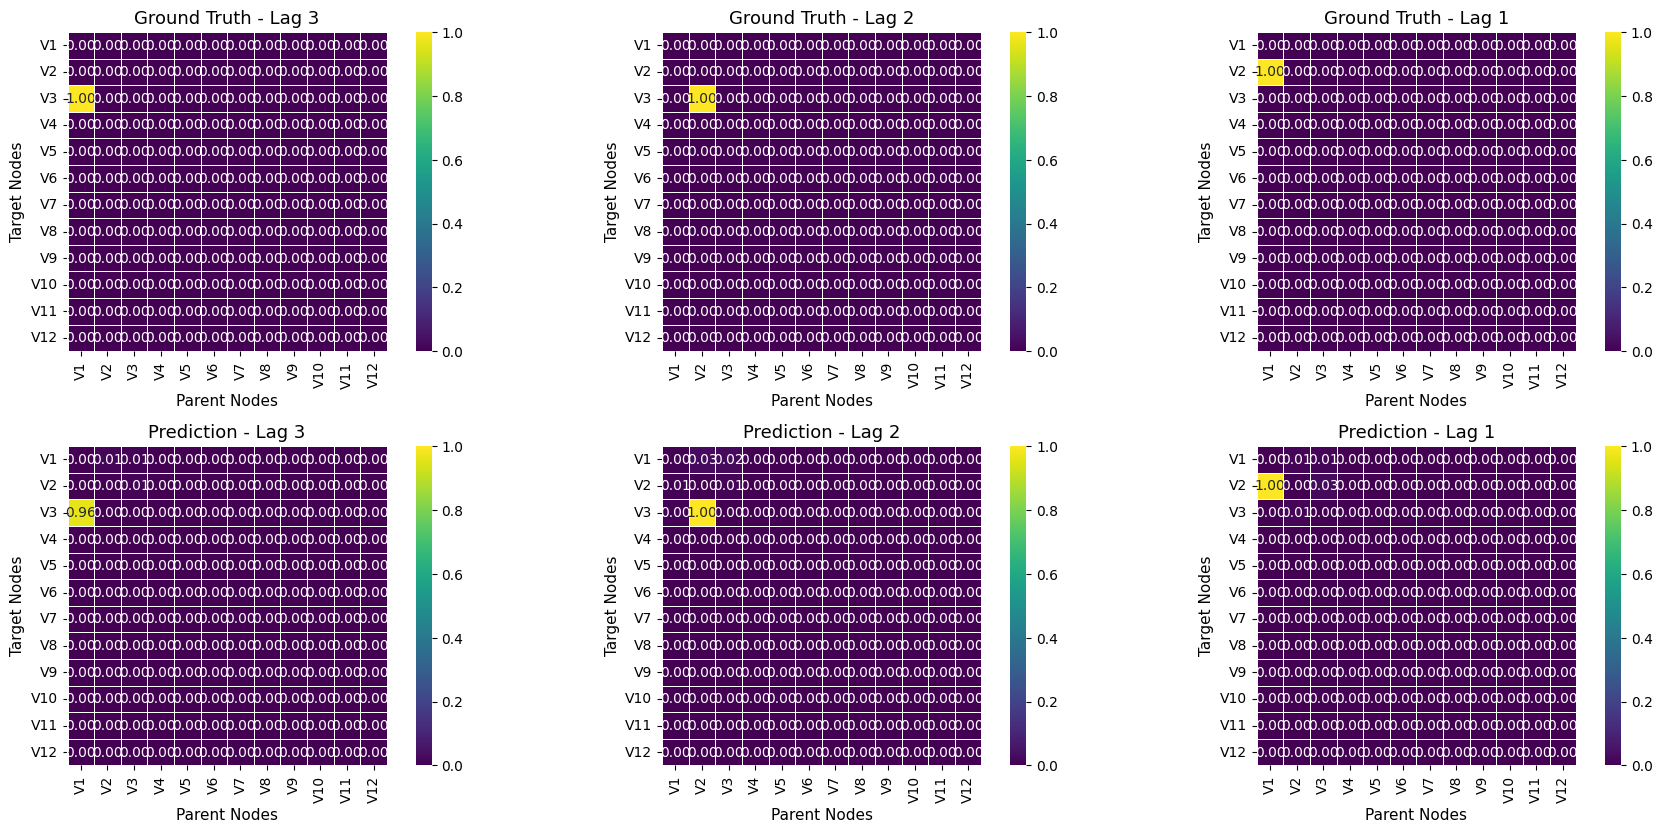

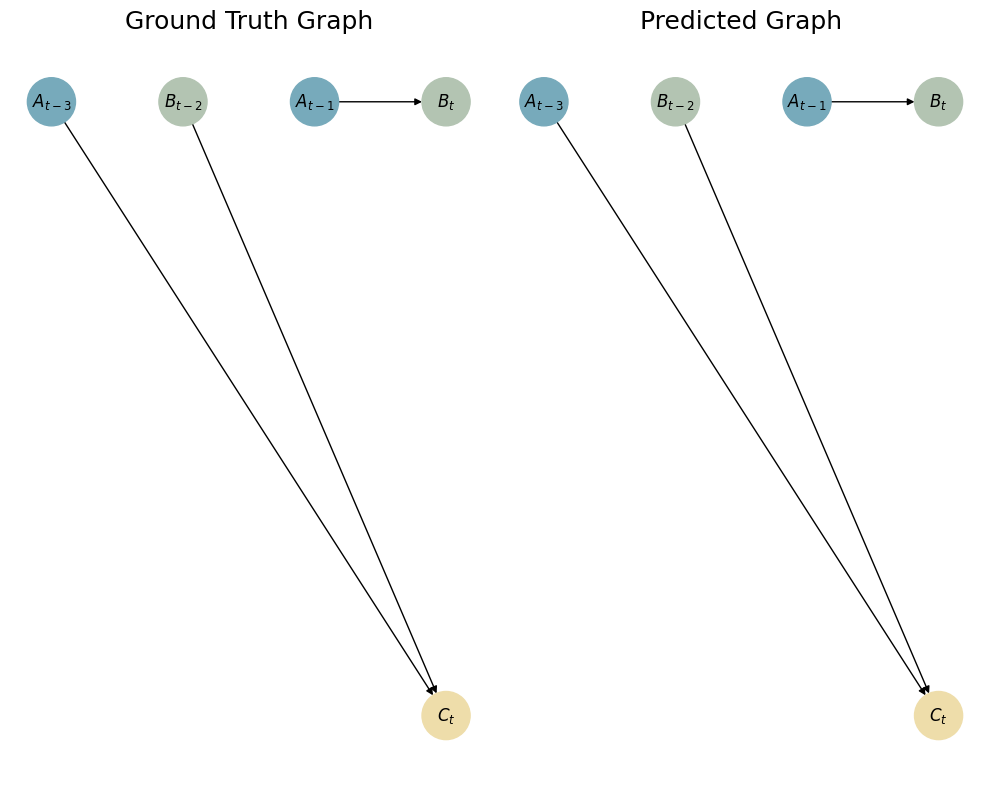

Ground truth edges: 3
Predicted edges: 3
AUC: 1.0000
TPR: 1.0000, FPR: 0.0000, TNR: 1.0000, FNR: 0.0000

AUC: 1.0


In [ ]:
#par_dir = Path.cwd().parent
model_path = Path("/media/nikolas/KINGSTON/LCM/logs")

model_dict = {
    "LCM_9.4M" : LCMModule.load_from_checkpoint(Path(model_path / "LCM_9.4M.ckpt"))
}

device = 'cpu'
for model_name, model in model_dict.items():
    print(f'__{model_name}__')
    M = model.model.to(device).eval()

# Model-specific params
MAX_SEQ_LEN = 500
MAX_LAG = 3
MAX_VAR = 12

X_cpd, Y_cpd = run_illustrative_example(n=MAX_SEQ_LEN)
X_cpd = torch.tensor(X_cpd.values, dtype=torch.float32)

print(f'Ground truth lagged causal graph shape: {Y_cpd.shape}')
print(f'Data sample shape: {X_cpd.shape}')

# Normalize and pad
X_cpd = (X_cpd - X_cpd.min()) / (X_cpd.max() - X_cpd.min())

# Noise padding  
if X_cpd.shape[0] < MAX_SEQ_LEN:
    X_cpd = torch.cat([X_cpd, torch.normal(0, 0.01, (MAX_SEQ_LEN - X_cpd.shape[0], X_cpd.shape[1]))], dim=0)

VAR_DIF, LAG_DIF = MAX_VAR - X_cpd.shape[1], MAX_LAG - Y_cpd.shape[2]
if VAR_DIF > 0:
    X_cpd = torch.cat([X_cpd, torch.normal(0, 0.01, (X_cpd.shape[0], VAR_DIF))], dim=1)
    Y_cpd = torch.nn.functional.pad(Y_cpd, (0, 0, 0, VAR_DIF, 0, VAR_DIF), value=0.0)

with torch.no_grad():
    corr = lagged_batch_crosscorrelation(X_cpd.unsqueeze(0), MAX_LAG)
    pred = torch.sigmoid(M((X_cpd.unsqueeze(0), corr)))
    for l in range(pred.shape[-1]):
        pred[:,l,l] = 0

print(f'Predicted lagged causal graph shape: {pred.shape}')

plot_adjacency_heatmaps(pred_adj=pred.squeeze(0), true_adj=Y_cpd, absolute_errors=False)
plot_comparison(label_lagged=Y_cpd, pred_lagged=pred.squeeze(0))

print(f'AUC: {custom_binary_metrics(pred, Y_cpd)[0]}')